# Graph methods for imaging, Vision, and computing (B31RX) 2025

## Tutorial 8: Variational Autoencoders (VAEs)

In this tutorial, we will explore the application of variational autoencoders (VAEs), a type of generative model capable of learning the underlying structure of data, for denoising images, specifically using the MNIST dataset of handwritten digits.

---

### Background

Image denoising is an essential preprocessing step in many computer vision and image processing applications. The goal is to remove noise from a given image while preserving the original details and structures as much as possible. Traditional denoising techniques, such as Gaussian filtering or total variation regularization, often struggle to balance noise removal and detail preservation.

In recent years, deep learning techniques, including autoencoders and their variants, have shown great potential in denoising tasks. Variational Autoencoders (VAEs) are one such deep learning model, primarily known for their generative capabilities.

- VAEs consist of an encoder network that maps input data to a latent space and a decoder network that reconstructs the input data from the latent space.
- By optimizing both the reconstruction loss and a regularization term that encourages the latent space to follow a specific distribution, VAEs can learn smooth and structured latent spaces, which can be advantageous for denoising tasks.

In this tutorial, we will adapt VAEs for image denoising using the MNIST dataset of handwritten digits. We will explore various aspects of VAEs in the context of denoising, such as:
- The effects of noise levels, latent space dimensions, network architecture, and loss functions.

By studying these factors, we aim to provide insights into the effective application of VAEs for denoising tasks and their potential improvements.

### Question 1

Execute the provided code for the VAE with a dense-layer architecture. In the context of the given implementation, explain how Variational Autoencoders (VAEs) differ from traditional autoencoders.

In [55]:
# Note: Some parts of this code (such as the VAE architecture and Sampling layer) are adapted from the official
# Keras VAE tutorial: https://keras.io/examples/generative/vae/

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # ensures 3D plotting support
from sklearn.decomposition import PCA

# --------------------------------------
# Define the Sampling Layer
# --------------------------------------
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

# --------------------------------------
# Define the VAE Model with a Custom Train Step
# --------------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.current_epoch = 0  # initialize current epoch

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Unpack the tuple: noisy input and clean target
        noisy, clean = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(noisy)
            reconstruction = self.decoder(z)
            # Compute the reconstruction loss against the clean image
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(clean, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # Pseudo-code for annealing beta:
            # current_beta = min(1.0, beta + (self.current_epoch / num_epochs))
            total_loss = reconstruction_loss + beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

class EpochTracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch = epoch

In [56]:
latent_dim = 3
num_epochs = 50
beta = 1
noise_stddev = 0.0

# --------------------------------------
# Build the Dense Encoder
# --------------------------------------
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --------------------------------------
# Build the Dense Decoder
# --------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# --------------------------------------
# Load and Preprocess MNIST Data
# --------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and add channel dimension
x_train = np.expand_dims(x_train[:10000], -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0
y_train = y_train[:10000]

def add_gaussian_noise(x, stddev=0.0):
    noise = np.random.normal(loc=0.0, scale=stddev, size=x.shape)
    x_noisy = x + noise
    # Clip values to keep them in [0, 1]
    return np.clip(x_noisy, 0., 1.)

# Add noise with a chosen standard deviation
x_train_noisy = add_gaussian_noise(x_train, stddev=noise_stddev)
x_test_noisy  = add_gaussian_noise(x_test, stddev=noise_stddev)

# --------------------------------------
# Create and Train the VAE
# --------------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train_noisy, x_train, epochs=num_epochs, batch_size=100, callbacks=[EpochTracker()])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_18 (Flatten)      │ (None, 784)            │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_86 (Dense)          │ (None, 512)            │        401,920 │ flatten_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_87 (Dense)          │ (None, 256)            │        131,328 │ dense_86[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 3)              │            771 │ dense_87[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 3)              │            771 │ dense_87[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_18 (Sampling)    │ (None, 3)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 534,790 (2.04 MB)

 Trainable params: 534,790 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_18 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,800 (2.04 MB)

 Trainable params: 534,800 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 12.0251 - loss: 289.9713 - reconstruction_loss: 277.9462
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 5.4083 - loss: 179.1748 - reconstruction_loss: 173.7664
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 6.0702 - loss: 165.1746 - reconstruction_loss: 159.1044
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 6.5046 - loss: 158.2968 - reconstruction_loss: 151.7923
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 6.7700 - loss: 154.7847 - reconstruction_loss: 148.0147
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 6.9626 - loss: 151.1976 - reconstruction_loss: 144.2350
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 7.1020 - loss: 148.9069 - reconstruction_loss: 141.8049
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 7.1891 - loss: 147.3353 - reconstruction_loss: 140.1462
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

### Question 2: Using the VAE for dimensionality reduction

Utilize the VAE to perform dimensionality reduction. Compare the latent space representations produced by the VAE for latent dimensions of 2 and 3 with those obtained using principal component analysis (PCA) applied to the raw data. Which method provides a more accurate and meaningful representation of the data?

Study and discuss the impact of changing the beta parameter (the regularization constant for the KL divergence term) on the structure of the latent space.

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


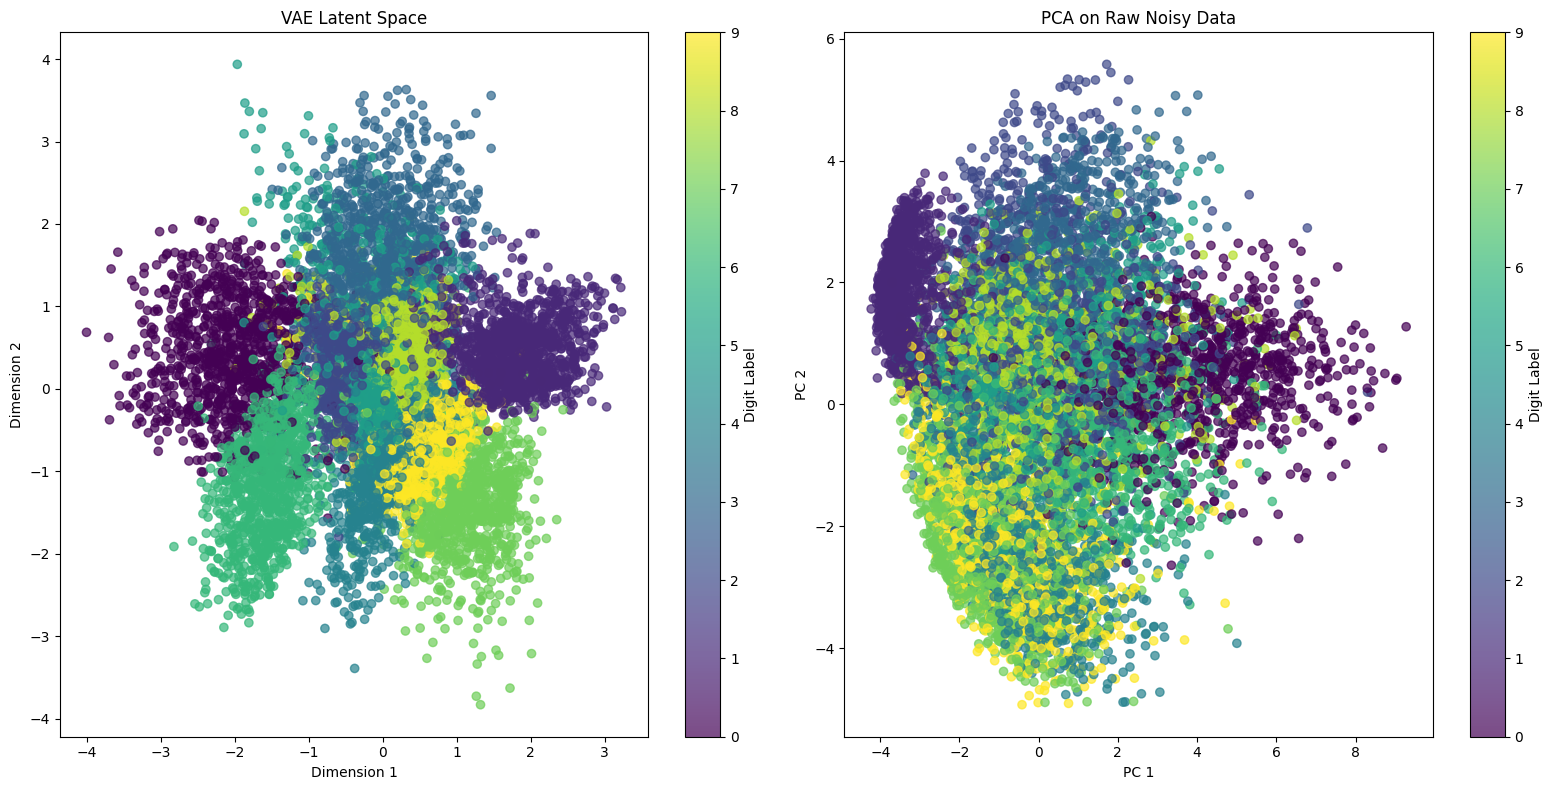

In [57]:
# -----------------------
# 1. Get VAE Latent Space
# -----------------------
# Use the encoder to get latent representations from the noisy images.
# Here we use z_mean as the latent code.
z_mean, _, _ = encoder.predict(x_test_noisy, batch_size=100)

# If the latent dimension is more than 2, reduce it to 2 using PCA for visualization.
if latent_dim > 2:
    pca_on_latent = PCA(n_components=2)
    z_2d_vae = pca_on_latent.fit_transform(z_mean)
else:
    z_2d_vae = z_mean

# -----------------------
# 2. Apply PCA on Raw Noisy Data
# -----------------------
# Flatten the images so each sample is a vector.
x_test_noisy_flattened = x_test_noisy.reshape(x_test_noisy.shape[0], -1)
pca_raw = PCA(n_components=2)
z_2d_raw = pca_raw.fit_transform(x_test_noisy_flattened)

# -----------------------
# 3. Plot Both Representations Side by Side
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# VAE latent space plot
sc1 = axes[0].scatter(z_2d_vae[:, 0], z_2d_vae[:, 1], c=y_test, cmap='viridis', alpha=0.7)
axes[0].set_title("VAE Latent Space")
axes[0].set_xlabel("Dimension 1")
axes[0].set_ylabel("Dimension 2")
fig.colorbar(sc1, ax=axes[0], label="Digit Label")

# PCA on raw noisy data plot
sc2 = axes[1].scatter(z_2d_raw[:, 0], z_2d_raw[:, 1], c=y_test, cmap='viridis', alpha=0.7)
axes[1].set_title("PCA on Raw Noisy Data")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
fig.colorbar(sc2, ax=axes[1], label="Digit Label")

plt.tight_layout()
plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


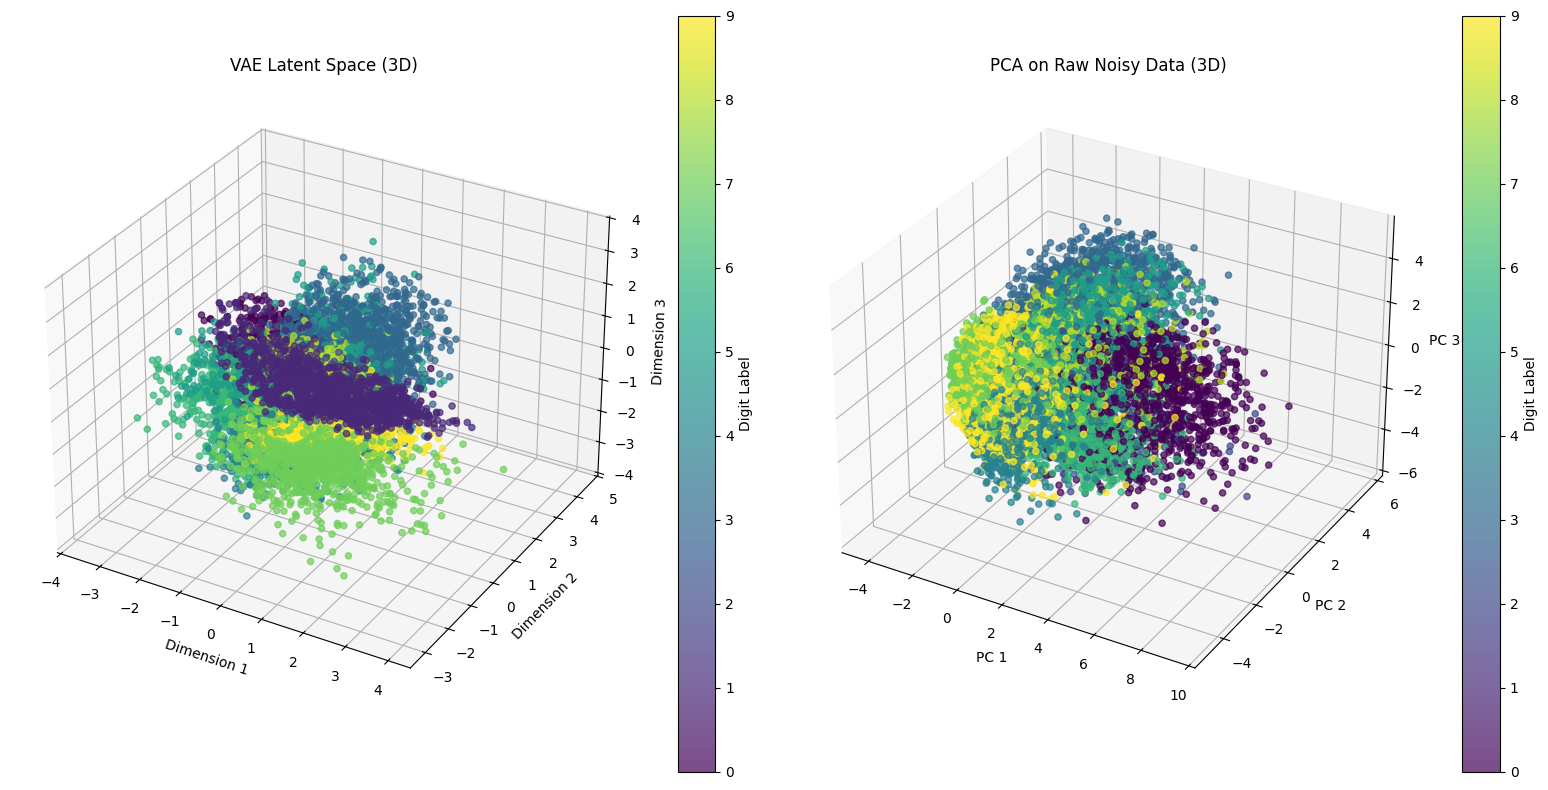

In [58]:
# -----------------------
# 1. Get VAE Latent Space (3D)
# -----------------------
# Use the encoder to get latent representations from the noisy images.
# Here we use z_mean as the latent code.
z_mean, _, _ = encoder.predict(x_test_noisy, batch_size=100)

# If the latent dimension is not 3, reduce it to 3 using PCA.
if z_mean.shape[1] != 3:
    pca_on_latent = PCA(n_components=3)
    z_3d_vae = pca_on_latent.fit_transform(z_mean)
else:
    z_3d_vae = z_mean

# -----------------------
# 2. Apply PCA on Raw Noisy Data (3D)
# -----------------------
# Flatten the images so each sample is a vector.
x_test_noisy_flat = x_test_noisy.reshape(x_test_noisy.shape[0], -1)
pca_raw = PCA(n_components=3)
z_3d_raw = pca_raw.fit_transform(x_test_noisy_flat)

# -----------------------
# 3. Plot Both Representations Side by Side in 3D
# -----------------------
fig = plt.figure(figsize=(16, 8))

# VAE latent space plot in 3D
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(z_3d_vae[:, 0], z_3d_vae[:, 1], z_3d_vae[:, 2],
                  c=y_test, cmap='viridis', alpha=0.7)
ax1.set_title("VAE Latent Space (3D)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.set_zlabel("Dimension 3")
fig.colorbar(sc1, ax=ax1, label="Digit Label")

# PCA on raw noisy data plot in 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(z_3d_raw[:, 0], z_3d_raw[:, 1], z_3d_raw[:, 2],
                  c=y_test, cmap='viridis', alpha=0.7)
ax2.set_title("PCA on Raw Noisy Data (3D)")
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")
fig.colorbar(sc2, ax=ax2, label="Digit Label")

plt.tight_layout()
plt.show()

### Question 3: Using the VAE as a generator

Utilize the trained VAE's generative capabilities to synthesize new, realistic handwritten digits that are not part of the original MNIST dataset.

Study and discuss the impact of changing the beta parameter and the latent dimension on the quality, diversity, and realism of the generated digits.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


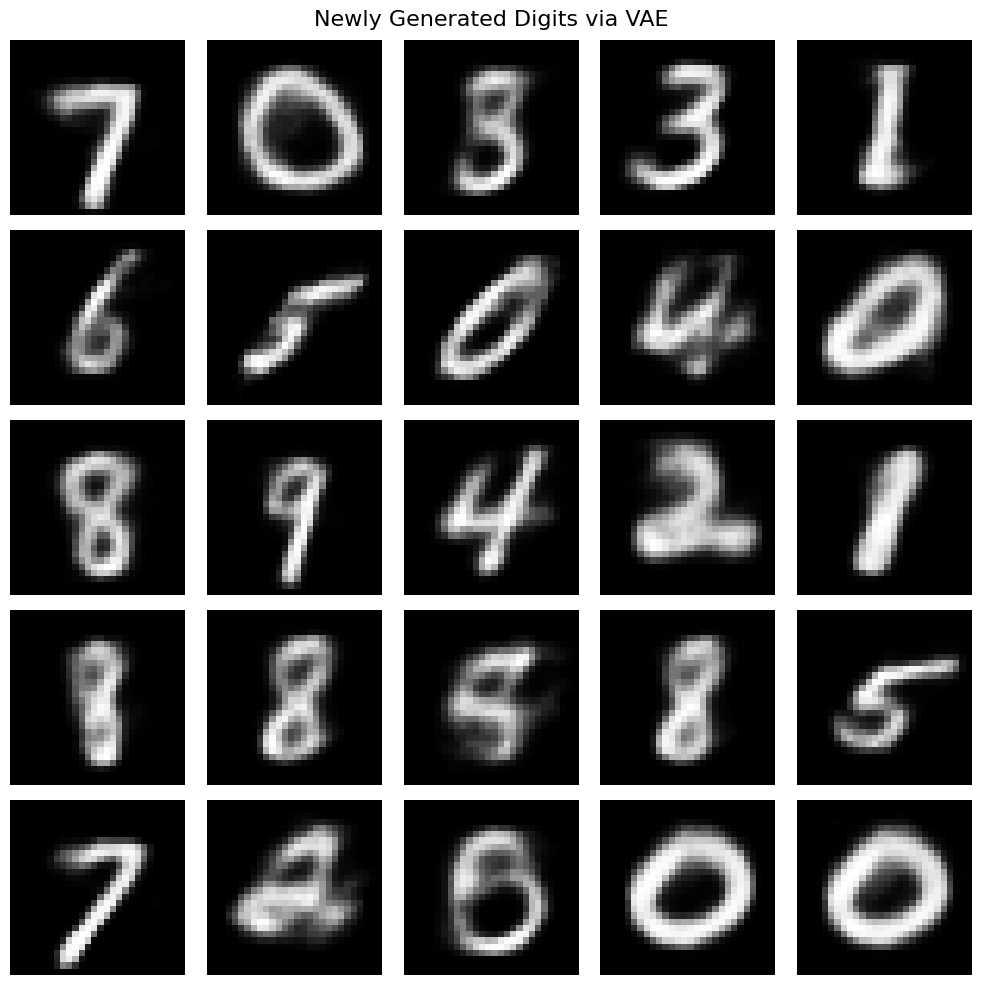

In [59]:
# Number of new images to generate
num_generated = 25

# Sample random latent vectors from a standard normal distribution
# Note: latent_dim is defined in your model (e.g., latent_dim = 2)
z_sample = np.random.normal(loc=0.0, scale=1.0, size=(num_generated, latent_dim))

# Use the decoder to generate new digit images
generated_images = decoder.predict(z_sample)

# Plot the generated images in a grid
plt.figure(figsize=(10, 10))
grid_size = int(np.sqrt(num_generated))
for i in range(num_generated):
    ax = plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Newly Generated Digits via VAE", fontsize=16)
plt.tight_layout()
plt.show()

### Question 4: Using the VAE for denoising

Add Gaussian noise to the input data. Investigate the effect of varying levels of noise on the performance of a VAE in denoising MNIST images. How does the VAE adapt to different noise levels, and what are the limitations?

Study and discuss the impact of changing the beta parameter and the latent space dimension on the quality of the denoised reconstructions.


In [60]:
latent_dim = 64
num_epochs = 50
beta = 0.1
noise_stddev = 0.3

# --------------------------------------
# Build the Dense Encoder
# --------------------------------------
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --------------------------------------
# Build the Dense Decoder
# --------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# --------------------------------------
# Load and Preprocess MNIST Data
# --------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and add channel dimension
x_train = np.expand_dims(x_train[:10000], -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0
y_train = y_train[:10000]

def add_gaussian_noise(x, stddev=0.0):
    noise = np.random.normal(loc=0.0, scale=stddev, size=x.shape)
    x_noisy = x + noise
    # Clip values to keep them in [0, 1]
    return np.clip(x_noisy, 0., 1.)

# Add noise with a chosen standard deviation
x_train_noisy = add_gaussian_noise(x_train, stddev=noise_stddev)
x_test_noisy  = add_gaussian_noise(x_test, stddev=noise_stddev)

# --------------------------------------
# Create and Train the VAE
# --------------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train_noisy, x_train, epochs=num_epochs, batch_size=100, callbacks=[EpochTracker()])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_19 (Flatten)      │ (None, 784)            │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_91 (Dense)          │ (None, 512)            │        401,920 │ flatten_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_92 (Dense)          │ (None, 256)            │        131,328 │ dense_91[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense_92[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense_92[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_19 (Sampling)    │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 566,144 (2.16 MB)

 Trainable params: 566,144 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_19 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,416 (2.10 MB)

 Trainable params: 550,416 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 38.3091 - loss: 272.7518 - reconstruction_loss: 268.9209
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 38.5190 - loss: 161.2384 - reconstruction_loss: 157.3865
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 57.6842 - loss: 131.1676 - reconstruction_loss: 125.3992
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 65.0373 - loss: 119.0043 - reconstruction_loss: 112.5006
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 69.8017 - loss: 110.9049 - reconstruction_loss: 103.9247
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 73.2368 - loss: 105.7558 - reconstruction_loss: 98.4321
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 74.4710 - loss: 101.3712 - reconstruction_loss: 93.9241
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 75.7248 - loss: 97.8009 - reconstruction_loss: 90.2285
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


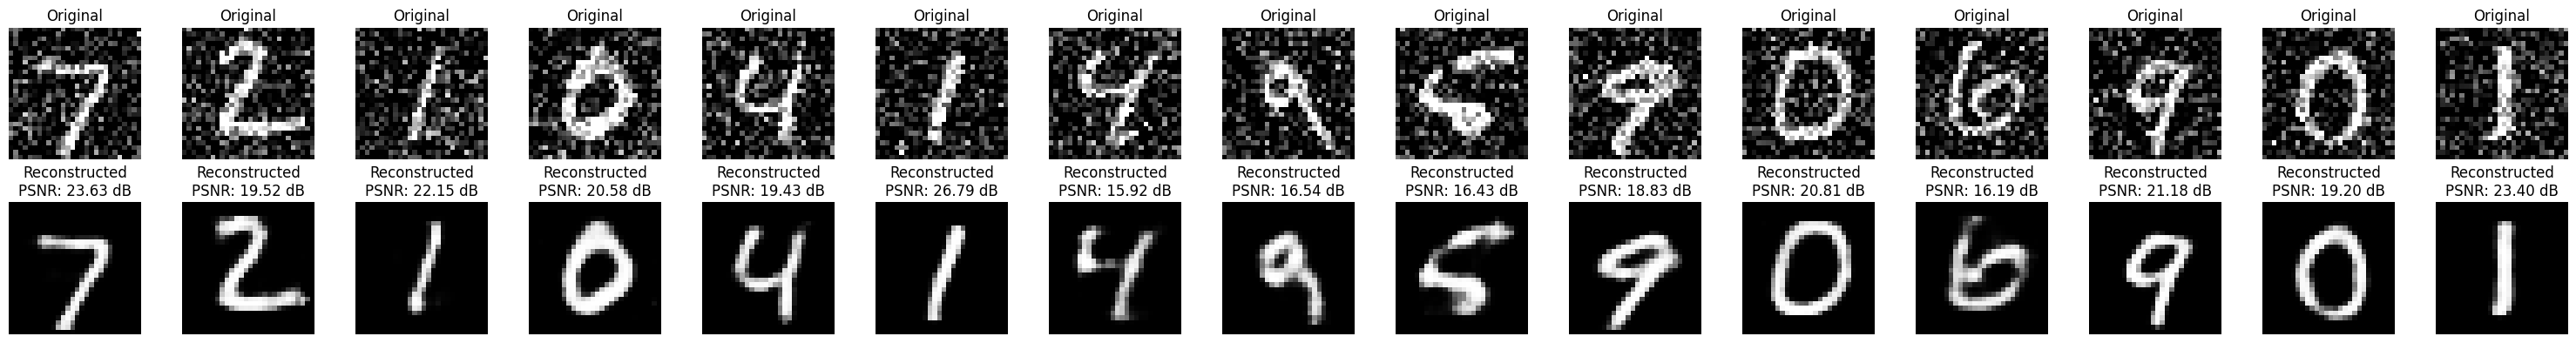

In [61]:
# Define a helper function to compute PSNR
def compute_psnr(original, reconstructed, max_val=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(mse))

# --------------------------------------
# Reconstruction and Plotting Results
# --------------------------------------
# Use the encoder to get latent representations and then the decoder to reconstruct images.
# We use the first 15 images from the test set for visualization.
num_images = 15
z_mean, z_log_var, z = encoder.predict(x_test_noisy[:num_images])
reconstructed = decoder.predict(z)

# Plot original and reconstructed images side by side with PSNR displayed for each reconstruction.
plt.figure(figsize=(2 * num_images, 4))
for i in range(num_images):
    # Original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Compute PSNR between the original (noisy) image and the reconstructed image.
    psnr_value = compute_psnr(x_test[i], reconstructed[i])

    # Reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed\nPSNR: {:.2f} dB".format(psnr_value))
    plt.axis("off")

plt.tight_layout()
plt.show()


### Question 5

Examine the impact of different types of noise (e.g., salt-and-pepper, or speckle noise) on the VAE's denoising performance for MNIST images. How does the VAE handle various noise types, and are there specific noise types that pose more significant challenges?

In [53]:
latent_dim = 64
num_epochs = 50
beta = 0.1
noise_stddev = 0.3

# --------------------------------------
# Build the Dense Encoder
# --------------------------------------
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_input")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --------------------------------------
# Build the Dense Decoder
# --------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# --------------------------------------
# Load and Preprocess MNIST Data
# --------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and add channel dimension
x_train = np.expand_dims(x_train[:10000], -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0
y_train = y_train[:10000]

def add_gaussian_noise(x, stddev=0.0):
    noise = np.random.normal(loc=0.0, scale=stddev, size=x.shape)
    x_noisy = x + noise
    # Clip values to keep them in [0, 1]
    return np.clip(x_noisy, 0., 1.)

def add_salt_and_pepper_noise(x, salt_prob=0.5, pepper_prob=0.1):
    """
    Adds salt and pepper noise to an image.

    Parameters:
    - x: Input image array with values in [0, 1].
    - salt_prob: Probability of adding salt (white pixels).
    - pepper_prob: Probability of adding pepper (black pixels).

    Returns:
    - Noisy image with some pixels set to 0 (pepper) or 1 (salt).
    """
    x_noisy = np.copy(x)
    random_matrix = np.random.rand(*x.shape)
    # Pepper noise: set pixels to 0
    x_noisy[random_matrix < pepper_prob] = 0.0
    # Salt noise: set pixels to 1
    x_noisy[random_matrix > 1 - salt_prob] = 1.0
    return x_noisy

def add_speckle_noise(x, stddev=0.1):
    """
    Adds speckle noise (multiplicative noise) to an image.

    Parameters:
    - x: Input image array with values in [0, 1].
    - stddev: Standard deviation of the noise.

    Returns:
    - Noisy image computed as x + x * noise.
    """
    noise = np.random.randn(*x.shape) * stddev
    x_noisy = x + x * noise
    return np.clip(x_noisy, 0., 1.)

# Add noise with a chosen standard deviation
# x_train_noisy = add_gaussian_noise(x_train, stddev=noise_stddev)
# x_test_noisy  = add_gaussian_noise(x_test, stddev=noise_stddev)

x_train_noisy = add_salt_and_pepper_noise(x_train, salt_prob=0.3, pepper_prob=0.1)
x_test_noisy  = add_salt_and_pepper_noise(x_test, salt_prob=0.3, pepper_prob=0.1)

# x_train_noisy = add_speckle_noise(x_train, stddev=0.3)
# x_test_noisy  = add_speckle_noise(x_test, stddev=0.3)

# --------------------------------------
# Create and Train the VAE
# --------------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train_noisy, x_train, epochs=num_epochs, batch_size=100, callbacks=[EpochTracker()])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 784)            │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_81 (Dense)          │ (None, 512)            │        401,920 │ flatten_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_82 (Dense)          │ (None, 256)            │        131,328 │ dense_81[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense_82[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense_82[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_17 (Sampling)    │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 566,144 (2.16 MB)

 Trainable params: 566,144 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_17 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,416 (2.10 MB)

 Trainable params: 550,416 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 44.3860 - loss: 271.6125 - reconstruction_loss: 267.1740
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 16.7703 - loss: 188.5797 - reconstruction_loss: 186.9027
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 38.9668 - loss: 158.6965 - reconstruction_loss: 154.7997
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 48.6626 - loss: 144.4228 - reconstruction_loss: 139.5565
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 52.4270 - loss: 136.1134 - reconstruction_loss: 130.8707
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 54.9436 - loss: 130.1870 - reconstruction_loss: 124.6927
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 57.3666 - loss: 125.6597 - reconstruction_loss: 119.9231
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 59.3101 - loss: 121.3357 - reconstruction_loss: 115.4047
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


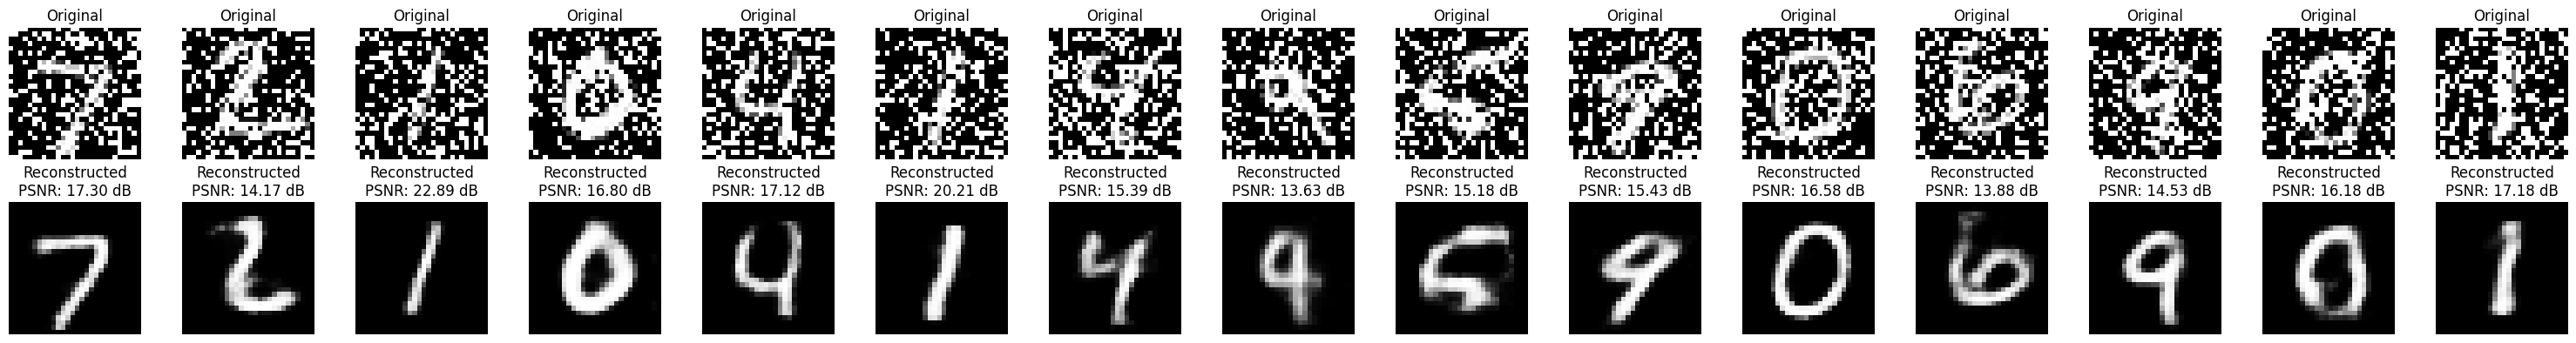

In [54]:
# --------------------------------------
# Reconstruction and Plotting Results
# --------------------------------------
# Use the encoder to get latent representations and then the decoder to reconstruct images.
# We use the first 15 images from the test set for visualization.
num_images = 15
z_mean, z_log_var, z = encoder.predict(x_test_noisy[:num_images])
reconstructed = decoder.predict(z)

# Plot original and reconstructed images side by side with PSNR displayed for each reconstruction.
plt.figure(figsize=(2 * num_images, 4))
for i in range(num_images):
    # Original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Compute PSNR between the original (noisy) image and the reconstructed image.
    psnr_value = compute_psnr(x_test[i], reconstructed[i])

    # Reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed\nPSNR: {:.2f} dB".format(psnr_value))
    plt.axis("off")

plt.tight_layout()
plt.show()

### Question 6

Enhance the VAE architecture by replacing the dense encoder/decoder with convolutional blocks.

Study and discuss the impact of this architectural change on dimensionality reduction, generation of new digits, and denoising performance.

In [50]:
latent_dim = 64
num_epochs = 50
beta = 0.1
noise_stddev = 0.3

# # --------------------------------------
# # Build the Encoder
# # --------------------------------------
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# # --------------------------------------
# # Build the Decoder
# # --------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# --------------------------------------
# Load and Preprocess MNIST Data
# --------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and add channel dimension
x_train = np.expand_dims(x_train[:10000], -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0
y_train = y_train[:10000]

x_train_noisy = add_salt_and_pepper_noise(x_train, salt_prob=0.3, pepper_prob=0.1)
x_test_noisy  = add_salt_and_pepper_noise(x_test, salt_prob=0.3, pepper_prob=0.1)

# --------------------------------------
# Create and Train the VAE
# --------------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train_noisy, x_train, epochs=num_epochs, batch_size=100, callbacks=[EpochTracker()])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │        200,768 │ flatten_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │        200,768 │ flatten_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_16 (Sampling)    │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 420,352 (1.60 MB)

 Trainable params: 420,352 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 3136)                │         203,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_16 (Reshape)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - kl_loss: 26.8581 - loss: 317.3596 - reconstruction_loss: 314.6739
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 19.2876 - loss: 204.7591 - reconstruction_loss: 202.8304
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 40.5243 - loss: 168.9456 - reconstruction_loss: 164.8932
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 69.1470 - loss: 128.7828 - reconstruction_loss: 121.8681
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 79.5273 - loss: 113.4293 - reconstruction_loss: 105.4765
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 82.8795 - loss: 104.9849 - reconstruction_loss: 96.6970
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 85.2974 - loss: 100.2972 - reconstruction_loss: 91.7674
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kl_loss: 85.8220 - loss: 96.9474 - reconstruction_loss: 88.3652
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


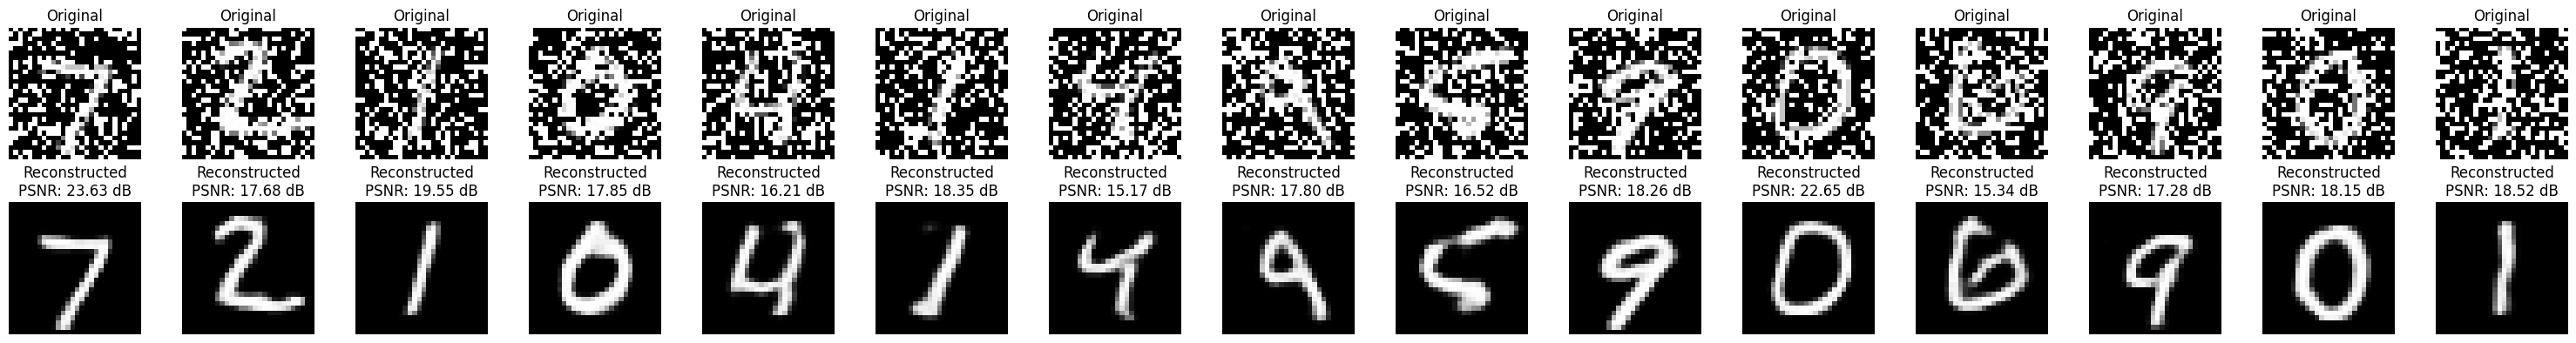

In [52]:
# --------------------------------------
# Reconstruction and Plotting Results
# --------------------------------------
# Use the encoder to get latent representations and then the decoder to reconstruct images.
# We use the first 15 images from the test set for visualization.
num_images = 15
z_mean, z_log_var, z = encoder.predict(x_test_noisy[:num_images])
reconstructed = decoder.predict(z)

# Plot original and reconstructed images side by side with PSNR displayed for each reconstruction.
plt.figure(figsize=(2 * num_images, 4))
for i in range(num_images):
    # Original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Compute PSNR between the original (noisy) image and the reconstructed image.
    psnr_value = compute_psnr(x_test[i], reconstructed[i])

    # Reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed\nPSNR: {:.2f} dB".format(psnr_value))
    plt.axis("off")

plt.tight_layout()
plt.show()